## Causal T-Learner Classifier

### TL; DR
---
This notebooks exemplifies how one can use the causal T-learner through fklearn.

### Long
---
A very interesting and useful type of causal models are uplift models, in which one is able to identify how each sample responds to a given treatment, and what is the effect of that treatment compared to a control group. The main goal of uplift models is, therefore, to learn the difference in probability of a sample converting (using a product), given that it was submitted to some action (nudge). Meta-learns are examples of causal models, in which the CATE represents how each unit will respond to a given treatment [1]. In fact, the uplift can be understood as the incremental gain in the conversion probability in the case a given sample was in the treatment group instead of the control one. In addition, these models have the advantage of using conventional machine learning models, such as LightGBM.

More specifically, the T-Learner is a meta-learner which learns the Conditional Average Treatment Effect (CATE) through the use of multiple models, one for each treatment. Each model is fitted in a subset of the data, according to the treatment. The CATE $\tau$ is defined as $\tau(x_{i}) = M_{1}(X=x_{i}, T=1) - M_{0}(X=x_{i}, T=0)$, being $M_{1}$ a model fitted with treatment data and $M_{0}$ a model fitted with control data, and they can be a Machine Learning Model such as a LightGBM Classifier and $x_{i}$ the feature set of sample $i$.

### Data
---
The data here adopted is provided in [1], [2].

### References
---

[1] https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html

[2] https://github.com/matheusfacure/python-causality-handbook/tree/master/causal-inference-for-the-brave-and-true/data

[3] https://causalml.readthedocs.io/en/latest/methodology.html

### 1. Imports

In [46]:
%reload_ext autoreload
%autoreload 2

In [47]:
import os

In [48]:
os.chdir("../src")
os.getcwd()

'/Users/eduardo.souza/dev/nu/fklearn/src'

In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from fklearn.causal.cate_learning.meta_learners import causal_t_classification_learner
from fklearn.training.classification import lgbm_classification_learner
from fklearn.training.calibration import isotonic_calibration_learner
from fklearn.causal.validation.curves import cumulative_gain_curve
from fklearn.training.pipeline import build_pipeline
from fklearn.training.transformation import ecdfer

sns.set_style("darkgrid")

### 2. Functions

In [50]:
def plot_cumulative_gain_curve(
    train_gain: np.ndarray,
    test_gain: np.ndarray,
    random_gain: np.ndarray,
    fontsize: int = 16,
    figsize: tuple = (15,5)
) -> None:
    """
    Plots the cumulative gain curve.
    """

    xaxis = np.arange(len(train_gain))/len(train_gain)
    
    plt.figure(figsize=figsize);
    plt.plot(xaxis, train_gain, label="Training Data");
    plt.plot(xaxis, test_gain, label="Testing Data");
    plt.plot(xaxis, random_gain, "--", label="Random");
               
    plt.ylabel("Cumulative Gain", fontsize=fontsize);
    plt.xlabel("Population Proportion", fontsize=fontsize);
    plt.title("Cumulative Gain Curve", fontsize=fontsize);
               
    plt.legend(fontsize=fontsize);
    plt.xticks(fontsize=fontsize);
    plt.yticks(fontsize=fontsize);

### 3. Read Data

Notice that the data here adopted is provided in [1] and [2].

In [51]:
test_data = pd.read_csv(
    "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/invest_email_rnd.csv"
)
train_data = pd.read_csv(
    "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/invest_email_biased.csv"
)

In [52]:
test_data.shape

(15000, 8)

In [53]:
train_data.shape

(15000, 8)

#### 3.1 Include Treatment Column

In [54]:
train_data["control"] = np.where((train_data["em1"]+train_data["em2"]+train_data["em3"])==0,1,0)
train_data["treatment_col"] = train_data[["em1","em2","em3","control"]].idxmax(axis=1).values

test_data["control"] = np.where((test_data["em1"]+test_data["em2"]+test_data["em3"])==0,1,0)
test_data["treatment_col"] = test_data[["em1","em2","em3","control"]].idxmax(axis=1).values

In [55]:
train_data.head()

,age,income,insurance,invested,em1,em2,em3,converted,control,treatment_col
0,44.1,5483.80,6155.29,14294.81,0,0,1,0,0,em3
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,0,em1
2,49.0,2712.51,5707.08,5095.65,0,0,1,1,0,em3
3,39.7,2326.37,15657.97,6345.20,0,0,0,0,1,control
4,35.3,2787.26,27074.44,14114.86,1,1,0,0,0,em1


In [56]:
test_data.head()

,age,income,insurance,invested,em1,em2,em3,converted,control,treatment_col
0,44.1,5483.80,6155.29,14294.81,0,1,1,0,0,em2
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,0,em1
2,49.0,2712.51,5707.08,5095.65,1,0,1,1,0,em1
3,39.7,2326.37,15657.97,6345.20,1,1,1,0,0,em1
4,35.3,2787.26,27074.44,14114.86,1,1,1,0,0,em1


### 4. Causal T-Learner

In [57]:
target_column = "converted"
features = ["age", "income", "insurance", "invested"]
treatment_column = "treatment_col"
control_name = "control"
prediction_column = "prediction"

#### 4.1 Using T-Learner with LightGBM

In [58]:
clf_learner = lgbm_classification_learner(
    features = features,
    target = target_column,
    prediction_column = prediction_column
)

In [59]:
t_learner = causal_t_classification_learner(
    treatment_col=treatment_column,
    control_name=control_name,
    prediction_column=prediction_column,
    learner=clf_learner,
    treatment_learner=clf_learner,
)

**Training the model**

In [60]:
t_learner_fcn, t_learner_train_df, t_learner_log = t_learner(train_data)

/Users/eduardo.souza/dev/nu/fklearn/venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/eduardo.souza/dev/nu/fklearn/venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/eduardo.souza/dev/nu/fklearn/venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future 

[LightGBM] [Info] Number of positive: 504, number of negative: 3808
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 4312, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116883 -> initscore=-2.022283
[LightGBM] [Info] Start training from score -2.022283
[LightGBM] [Info] Number of positive: 1392, number of negative: 5088
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 6480, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214815 -> initscore=-1.296143
[LightGBM] [Info] Start training from score -1.296143
[LightGBM] [Info]

/Users/eduardo.souza/dev/nu/fklearn/venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


In [61]:
t_learner_fcn

<function fklearn.causal.cate_learning.meta_learners.causal_t_classification_learner.<locals>.p(new_df: pandas.core.frame.DataFrame) -> pandas.core.frame.DataFrame>

In [62]:
t_learner_train_df.head()

,age,income,insurance,invested,em1,em2,em3,converted,control,treatment_col,treatment_em3__uplift,treatment_em1__uplift,treatment_em2__uplift,uplift,suggested_treatment
0,44.1,5483.80,6155.29,14294.81,0,0,1,0,0,em3,0.079825,0.268265,0.128590,0.268265,treatment_em1
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,0,em1,-0.003786,-0.031755,-0.080341,-0.003786,control
2,49.0,2712.51,5707.08,5095.65,0,0,1,1,0,em3,0.418073,0.636309,0.014836,0.636309,treatment_em1
3,39.7,2326.37,15657.97,6345.20,0,0,0,0,1,control,0.036714,0.207071,0.147338,0.207071,treatment_em1
4,35.3,2787.26,27074.44,14114.86,1,1,0,0,0,em1,0.140358,0.192001,0.072842,0.192001,treatment_em1


In [63]:
t_learner_log

{'causal_t_classification_learner': {'control': {'lgbm_classification_learner': {'features': ['age',
     'income',
     'insurance',
     'invested'],
    'target': 'converted',
    'prediction_column': 'prediction',
    'package': 'lightgbm',
    'package_version': '3.3.2',
    'parameters': {'eta': 0.1, 'objective': 'binary', 'num_estimators': 100},
    'feature_importance': {'age': 739,
     'income': 811,
     'insurance': 724,
     'invested': 726},
    'training_samples': 4312,
    'running_time': '0.087 s'},
   'object': <lightgbm.basic.Booster at 0x13c737ca0>},
  'em3': {'lgbm_classification_learner': {'features': ['age',
     'income',
     'insurance',
     'invested'],
    'target': 'converted',
    'prediction_column': 'prediction',
    'package': 'lightgbm',
    'package_version': '3.3.2',
    'parameters': {'eta': 0.1, 'objective': 'binary', 'num_estimators': 100},
    'feature_importance': {'age': 627,
     'income': 772,
     'insurance': 816,
     'invested': 785},
  

In [64]:
score_of_interest = "treatment_em1__uplift"

**Making Predictions**

In [65]:
t_learner_test_df = t_learner_fcn(test_data)

In [66]:
t_learner_test_df.head()

,age,income,insurance,invested,em1,em2,em3,converted,control,treatment_col,treatment_em3__uplift,treatment_em1__uplift,treatment_em2__uplift,uplift,suggested_treatment
0,44.1,5483.80,6155.29,14294.81,0,1,1,0,0,em2,0.079825,0.268265,0.128590,0.268265,treatment_em1
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,0,em1,-0.003786,-0.031755,-0.080341,-0.003786,control
2,49.0,2712.51,5707.08,5095.65,1,0,1,1,0,em1,0.418073,0.636309,0.014836,0.636309,treatment_em1
3,39.7,2326.37,15657.97,6345.20,1,1,1,0,0,em1,0.036714,0.207071,0.147338,0.207071,treatment_em1
4,35.3,2787.26,27074.44,14114.86,1,1,1,0,0,em1,0.140358,0.192001,0.072842,0.192001,treatment_em1


**Create Random Score**

Let's also create a random score that can be used to compute the Cumulative Gain curve.

In [67]:
random_score_df = test_data[["em1", target_column]].copy()
random_score_df[score_of_interest] = np.random.uniform(0,1,random_score_df.shape[0])

**Checking Cumulative Gain Curve**

For more details about causal models evaluation, please look at the following reference:

https://matheusfacure.github.io/python-causality-handbook/19-Evaluating-Causal-Models.html?highlight=gain%20curve    

In [70]:
gain_curve = cumulative_gain_curve(
    treatment = "em1",
    outcome = target_column,
    prediction = score_of_interest
)

In [71]:
gain_curve_train = gain_curve(t_learner_train_df)
gain_curve_test = gain_curve(t_learner_test_df)
gain_curve_random = gain_curve(random_score_df)

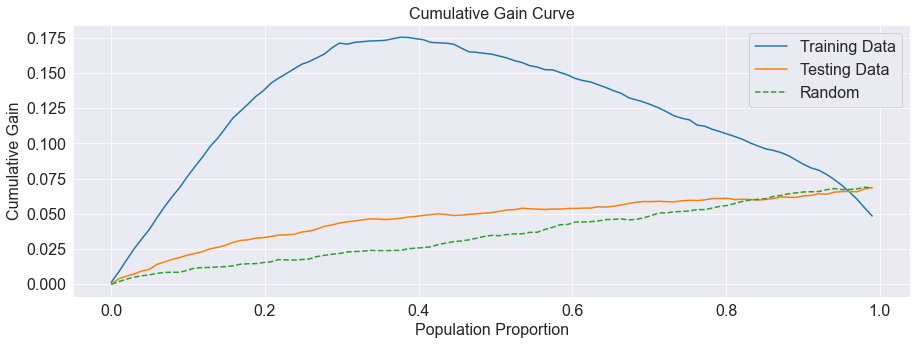

In [72]:
plot_cumulative_gain_curve(
    train_gain = gain_curve_train,
    test_gain = gain_curve_test,
    random_gain = gain_curve_random
)

#### 4.2 Using T-Learner with Fklearn Pipeline

In [73]:
cdf = ecdfer(
    prediction_column=score_of_interest
)

In [74]:
pipeline = build_pipeline(
    *[t_learner, cdf]
)

In [75]:
pipe_fcn, pipe_train_df, pipe_log = pipeline(
    train_data
)

/Users/eduardo.souza/dev/nu/fklearn/venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/eduardo.souza/dev/nu/fklearn/venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/eduardo.souza/dev/nu/fklearn/venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future 

[LightGBM] [Info] Number of positive: 504, number of negative: 3808
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 4312, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116883 -> initscore=-2.022283
[LightGBM] [Info] Start training from score -2.022283
[LightGBM] [Info] Number of positive: 1392, number of negative: 5088
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 6480, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214815 -> initscore=-1.296143
[LightGBM] [Info] Start training from score -1.296143
[LightGBM] [Info]

/Users/eduardo.souza/dev/nu/fklearn/venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


In [76]:
pipe_train_df.head()

,age,income,insurance,invested,em1,em2,em3,converted,control,treatment_col,treatment_em3__uplift,treatment_em1__uplift,treatment_em2__uplift,uplift,suggested_treatment,prediction_ecdf
0,44.1,5483.80,6155.29,14294.81,0,0,1,0,0,em3,0.079825,0.268265,0.128590,0.268265,treatment_em1,754.266667
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,0,em1,-0.003786,-0.031755,-0.080341,-0.003786,control,110.066667
2,49.0,2712.51,5707.08,5095.65,0,0,1,1,0,em3,0.418073,0.636309,0.014836,0.636309,treatment_em1,989.133333
3,39.7,2326.37,15657.97,6345.20,0,0,0,0,1,control,0.036714,0.207071,0.147338,0.207071,treatment_em1,653.533333
4,35.3,2787.26,27074.44,14114.86,1,1,0,0,0,em1,0.140358,0.192001,0.072842,0.192001,treatment_em1,622.666667


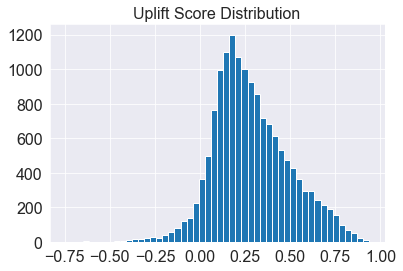

In [77]:
pipe_train_df["uplift"].hist(bins=50);
plt.title("Uplift Score Distribution", fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

**Checking Gain Curve with ECDF**

In [79]:
gain_curve = cumulative_gain_curve(
    treatment = "em1",
    outcome = target_column,
    prediction = "prediction_ecdf"
)

In [80]:
pipeline_train_df = pipe_fcn(train_data)
pipeline_test_df = pipe_fcn(test_data)

In [81]:
gain_curve_train = gain_curve(pipeline_train_df)
gain_curve_test = gain_curve(pipeline_test_df)

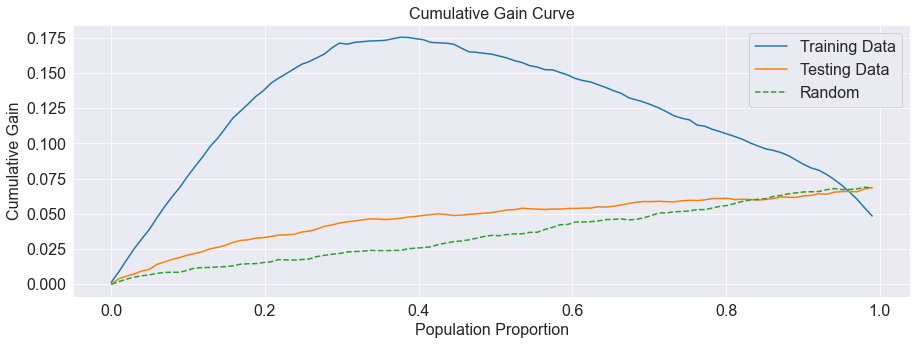

In [82]:
plot_cumulative_gain_curve(
    train_gain = gain_curve_train,
    test_gain = gain_curve_test,
    random_gain = gain_curve_random
)

#### 4.3 Build T-learner Using Lightgbm with Isotonic Calibration

In [83]:
clf_learner = lgbm_classification_learner(
    features = features,
    target = target_column,
    prediction_column = prediction_column
)

In [84]:
calibrator = isotonic_calibration_learner(
    target_column=target_column,
    prediction_column=prediction_column,
    output_column="calibration_prediction"
)

In [95]:
t_learner = causal_t_classification_learner(
    treatment_col=treatment_column,
    control_name=control_name,
    prediction_column="calibration_prediction",
    learner=clf_learner,
    learner_transformers=[calibrator]
)

In [96]:
cdf = ecdfer(
    prediction_column=score_of_interest
)

In [97]:
pipeline = build_pipeline(
    *[t_learner, cdf]
)

In [98]:
pipe_fcn, pipe_train_df, pipe_log = pipeline(
    train_data
)

/Users/eduardo.souza/dev/nu/fklearn/venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/eduardo.souza/dev/nu/fklearn/venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 504, number of negative: 3808
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 4312, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116883 -> initscore=-2.022283
[LightGBM] [Info] Start training from score -2.022283
[LightGBM] [Info] Number of positive: 1392, number of negative: 5088
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 6480, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214815 -> initscore=-1.296143
[LightGBM] [Info] Start training from score -1.296143


/Users/eduardo.souza/dev/nu/fklearn/venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/eduardo.souza/dev/nu/fklearn/venv/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 802, number of negative: 2568
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 958
[LightGBM] [Info] Number of data points in the train set: 3370, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237982 -> initscore=-1.163774
[LightGBM] [Info] Start training from score -1.163774
[LightGBM] [Info] Number of positive: 309, number of negative: 529
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 838, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368735 -> initscore=-0.537647
[LightGBM] [Info] Start training from score -0.537647
[LightGBM] [Warning]

In [99]:
pipe_train_df.head()

,age,income,insurance,invested,em1,em2,em3,converted,control,treatment_col,treatment_em3__calibration_prediction_on_treatment,treatment_em3__uplift,treatment_em1__calibration_prediction_on_treatment,treatment_em1__uplift,treatment_em2__calibration_prediction_on_treatment,treatment_em2__uplift,uplift,suggested_treatment,prediction_ecdf
0,44.1,5483.80,6155.29,14294.81,0,0,1,0,0,em3,0.338983,0.200429,0.820755,0.682201,0.0,-0.138554,0.682201,treatment_em1,813.133333
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,0,em1,0.000000,-0.001727,0.000000,-0.001727,0.0,-0.001727,-0.001727,control,225.400000
2,49.0,2712.51,5707.08,5095.65,0,0,1,1,0,em3,0.883333,0.883333,0.982558,0.982558,0.0,0.000000,0.982558,treatment_em1,997.333333
3,39.7,2326.37,15657.97,6345.20,0,0,0,0,1,control,0.000000,0.000000,0.140625,0.140625,0.0,0.000000,0.140625,treatment_em1,606.133333
4,35.3,2787.26,27074.44,14114.86,1,1,0,0,0,em1,0.010050,0.010050,0.033951,0.033951,0.0,0.000000,0.033951,treatment_em1,518.400000


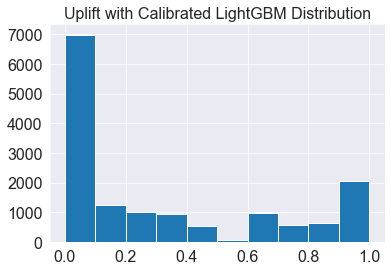

In [100]:
pipe_train_df["treatment_em1__calibration_prediction_on_treatment"].hist(bins=10);
plt.title("Uplift with Calibrated LightGBM Distribution", fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

**Checking Gain Curve with ECDF**

In [91]:
gain_curve = cumulative_gain_curve(
    treatment = "em1",
    outcome = target_column,
    prediction = "prediction_ecdf"
)

In [92]:
pipeline_train_df = pipe_fcn(train_data)
pipeline_test_df = pipe_fcn(test_data)

In [93]:
gain_curve_train = gain_curve(pipeline_train_df)
gain_curve_test = gain_curve(pipeline_test_df)

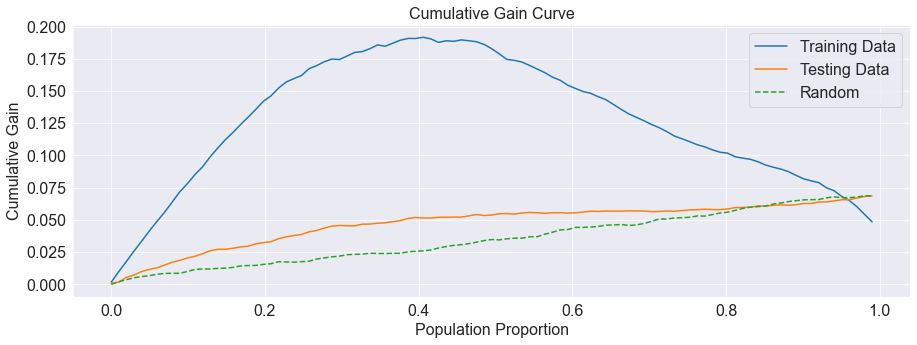

In [94]:
plot_cumulative_gain_curve(
    train_gain = gain_curve_train,
    test_gain = gain_curve_test,
    random_gain = gain_curve_random
)